# Simulated sparse transitions data

In [11]:
import ocelli as oci
import matplotlib as mpl
import scanpy as scp

mpl.rcParams['figure.dpi'] = 200

SEED = 17

## Load the data

In [15]:
adata = scp.read_h5ad('../../../data/sparse-transitions-dataset.h5ad')
adata

AnnData object with n_obs × n_vars = 4500 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'modalities'
    obsm: 'modality0', 'modality1'

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

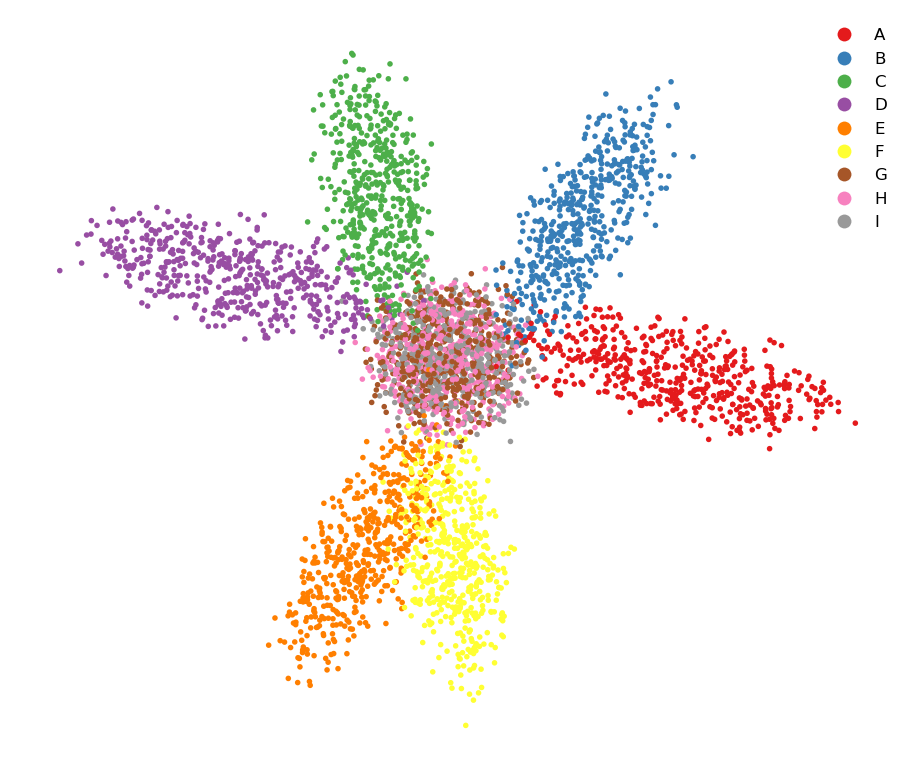

In [8]:
oci.tl.project_2d(adata, x3d_key='modality0', output_key='modality0_proj', alpha=-45, beta=120)
oci.pl.scatter(adata, x_key='modality0_proj', color_key='celltype', marker_size=1, cmap='Set1')

The second view:

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

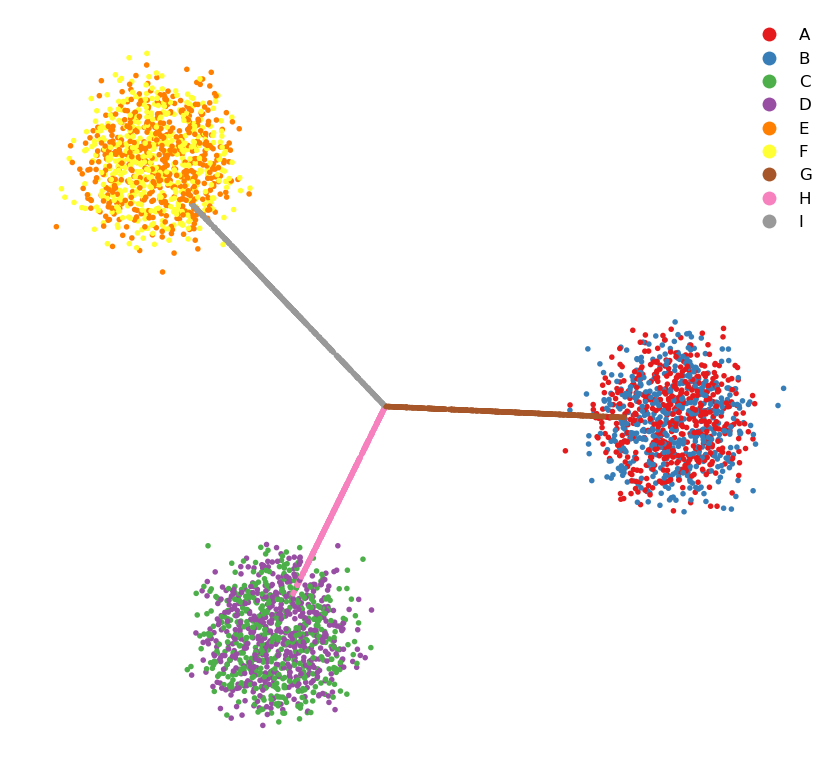

In [9]:
oci.tl.project_2d(adata, x3d_key='modality1', output_key='modality1_proj', alpha=-45, beta=60)
oci.pl.scatter(adata, x_key='modality1_proj', color_key='celltype', marker_size=1, cmap='Set1')

The first view differentiates well between celltypes A-F, while G-I are mixed up. An inverse situation happens in the second view.

Now, we save begin the analysis, by defining which x.obsm keys store views.

Subsequently, we calculate nearest neighbors and multi-view weights.

## Calculate Multimodal Diffusion Maps components

In [12]:
oci.pp.neighbors(adata, n_neighbors=60, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
adata

60 nearest neighbors calculated.


2022-09-26 22:38:52,575	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal cell-specific weights estimated.


AnnData object with n_obs × n_vars = 4500 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'modalities', 'neighbors', 'distances', 'epsilons'
    obsm: 'modality0', 'modality1', 'modality0_proj', 'modality1_proj', 'weights'

Let's see weights' distributions.

(<Figure size 1280x960 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'A'}, ylabel='modality0'>,
         <AxesSubplot:title={'center':'B'}>,
         <AxesSubplot:title={'center':'C'}>,
         <AxesSubplot:title={'center':'D'}>,
         <AxesSubplot:title={'center':'E'}>,
         <AxesSubplot:title={'center':'F'}>,
         <AxesSubplot:title={'center':'G'}>,
         <AxesSubplot:title={'center':'H'}>,
         <AxesSubplot:title={'center':'I'}>],
        [<AxesSubplot:ylabel='modality1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

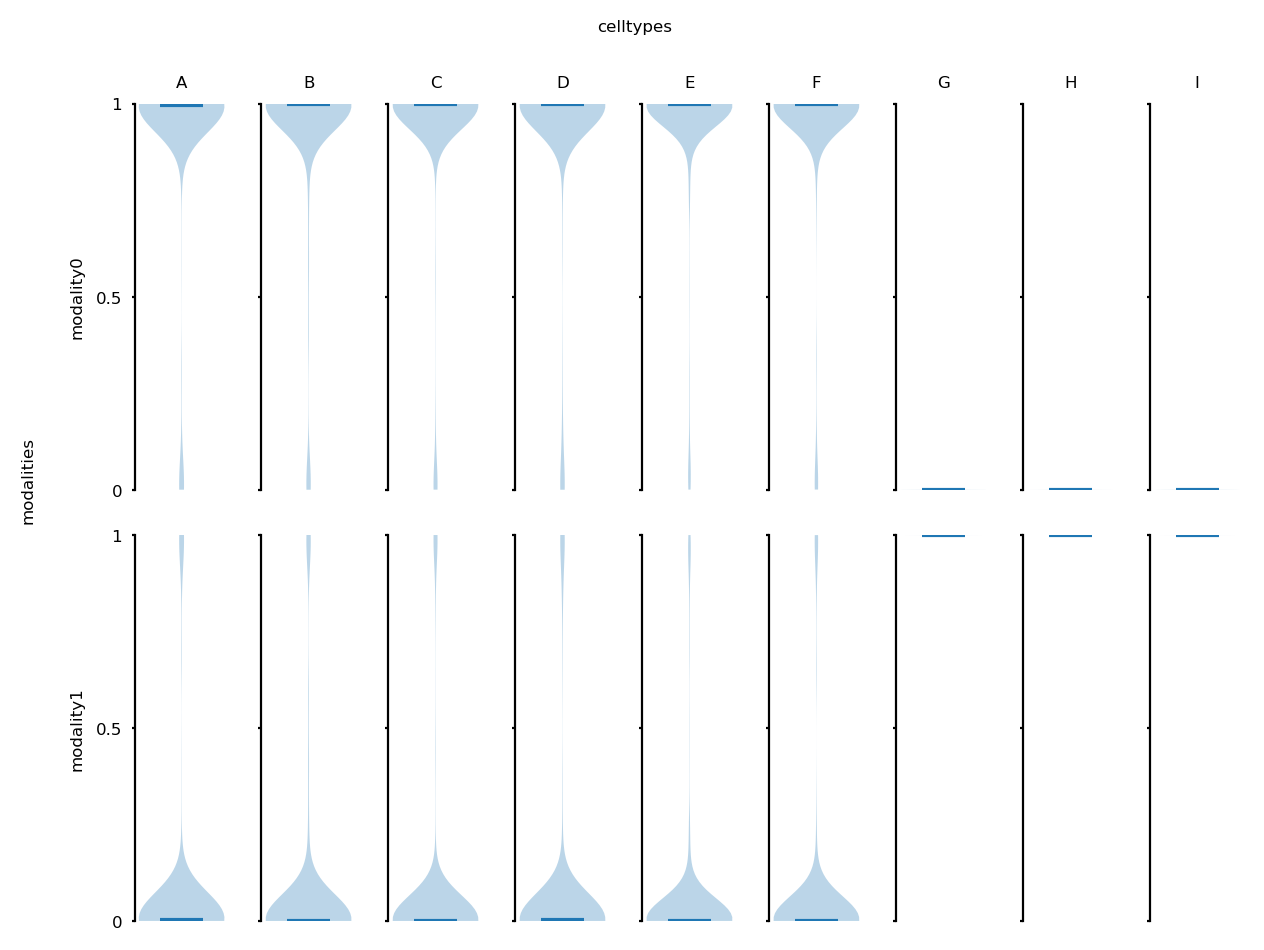

In [14]:
oci.pl.weights(adata)

MVDM correctly detected which views are noisy for which cell types.

The multi-view weights are then used to calculate the multi-view diffusion maps embedding. In this case, it is 20-dimensional.

In [17]:
oci.tl.MDM(adata, n_components=20, unimodal_norm=False, verbose=True, random_state=SEED)
adata

Unimodal Markov chain calculated (1/2)
Unimodal Markov chain calculated (2/2)
Multimodal Markov chain calculated
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.


AnnData object with n_obs × n_vars = 4500 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'modalities', 'neighbors', 'distances', 'epsilons'
    obsm: 'modality0', 'modality1', 'modality0_proj', 'modality1_proj', 'weights', 'X_mdm'

## Visualize the data

Now, the nearest neighbors graph is constructed by performing the nearest neighbors search in the multi-view diffusion maps space.

In [38]:
oci.pp.neighbors(adata, modalities=['X_mdm'], neighbors_key='neighbors_mdm', n_neighbors=75, verbose=True)
oci.tl.nn_graph(adata, n=75, neighbors_key='neighbors_mdm', verbose=True)
adata

75 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


AnnData object with n_obs × n_vars = 4500 × 1
    obs: 'celltype', 'pseudotime', 'w_m0', 'w_m1'
    uns: 'modalities', 'neighbors', 'distances', 'epsilons', 'neighbors_mdm'
    obsm: 'modality0', 'modality1', 'modality0_proj', 'modality1_proj', 'weights', 'X_mdm', 'graph', 'X_fa2'

The resulting nearest neighbors graph is visualized using the [ForceAtlas2](https://github.com/klarman-cell-observatory/forceatlas2) algorithm.

In [45]:
oci.tl.FA2(adata, n_components=2, n_steps=2000, random_state=SEED, output_key='X_fa2')
adata

Sep 26, 2022 10:52:25 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Sep 26, 2022 10:52:27 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 4,500 (4,500 added)
Sep 26, 2022 10:52:27 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 337,500 (190,540 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 18.385s


AnnData object with n_obs × n_vars = 4500 × 1
    obs: 'celltype', 'pseudotime', 'w_m0', 'w_m1'
    uns: 'modalities', 'neighbors', 'distances', 'epsilons', 'neighbors_mdm'
    obsm: 'modality0', 'modality1', 'modality0_proj', 'modality1_proj', 'weights', 'X_mdm', 'graph', 'X_fa2'

Let's have a look at dataset's metadata.

Cell types:

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

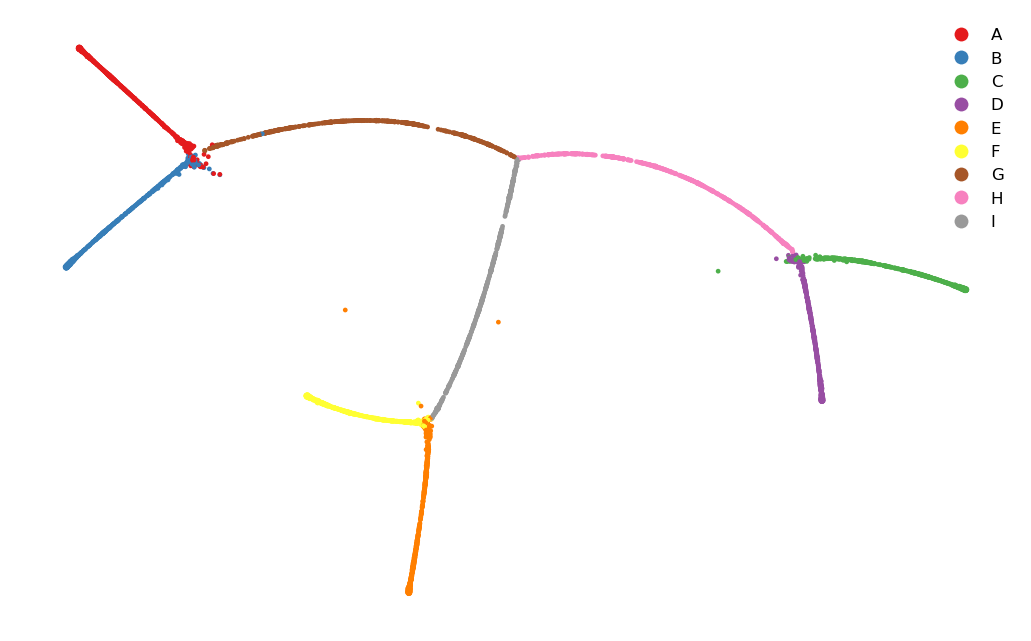

In [46]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='celltype', cmap='Set1', marker_size=0.5)

Cell development pseudotime:

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

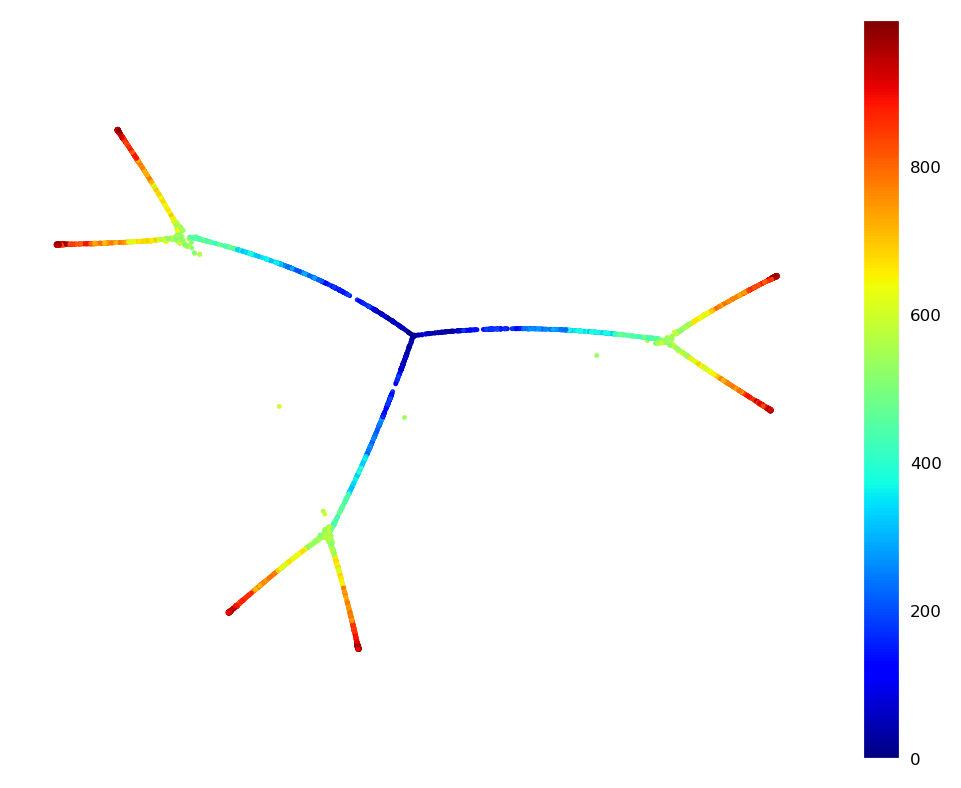

In [33]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='pseudotime', cmap='jet', marker_size=0.5)

The first view's weights:

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

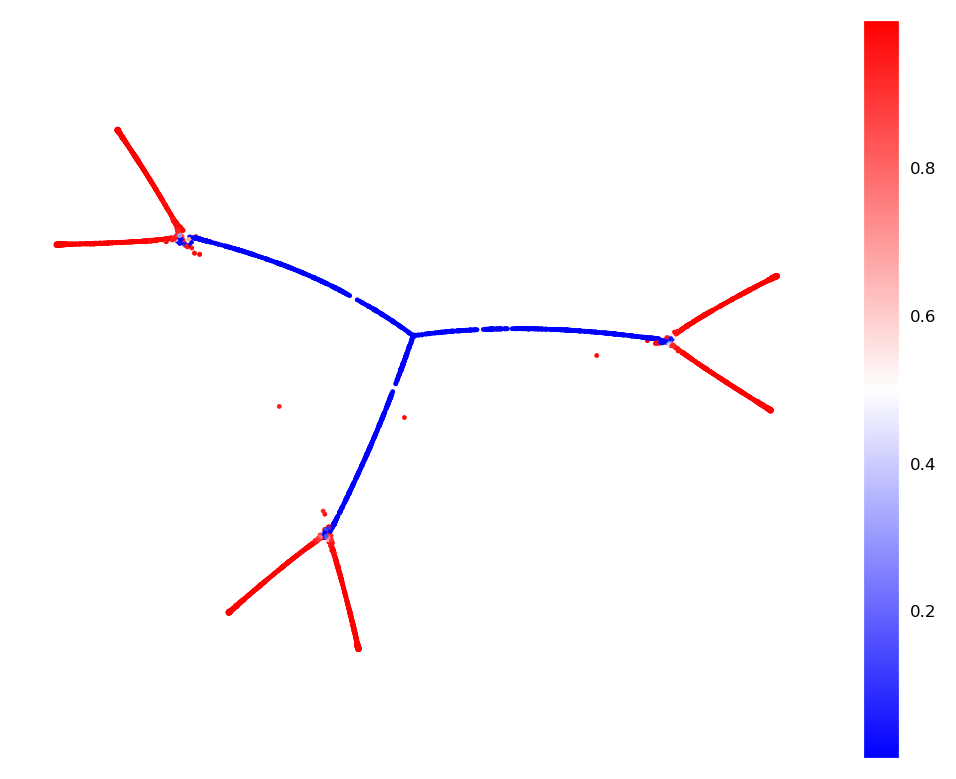

In [34]:
adata.obs['w_m0'] = list(adata.obsm['weights']['modality0'])
oci.pl.scatter(adata, x_key='X_fa2', color_key='w_m0', cmap='bwr', marker_size=0.5)

The second view's weights:

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

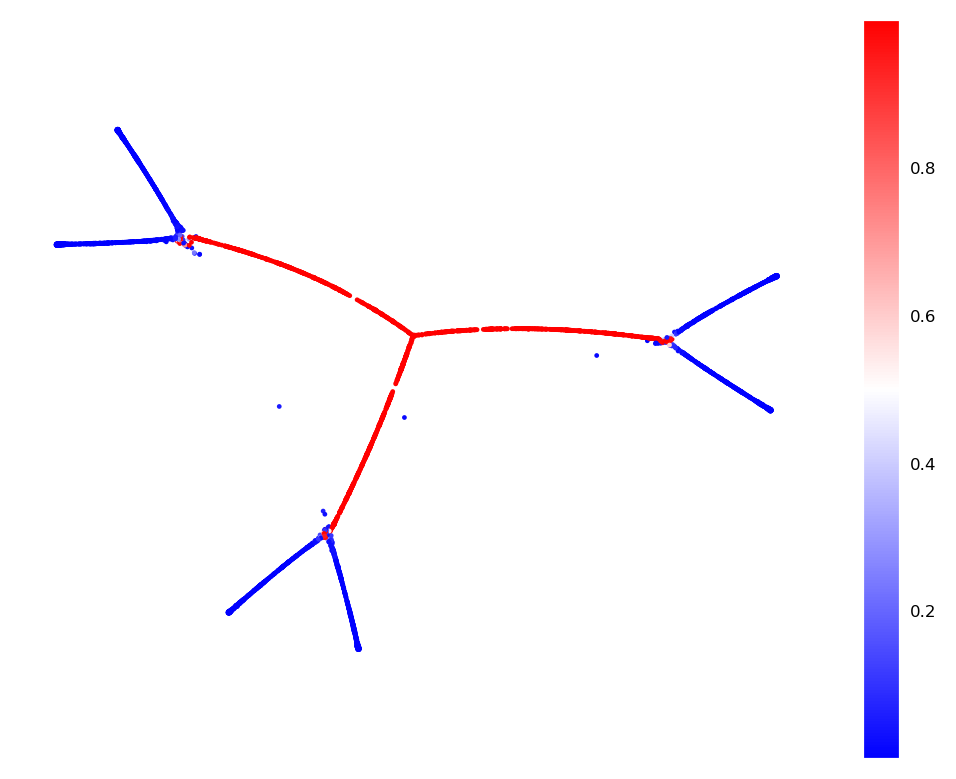

In [35]:
adata.obs['w_m1'] = list(adata.obsm['weights']['modality1'])
oci.pl.scatter(adata, x_key='X_fa2', color_key='w_m1', cmap='bwr', marker_size=0.5)